# Tutorial for a gene expression error model with spike-ins, biological replicates, on simulated data

In [1]:
import pymc as pm
import arviz as az
#import bebi103

import numpy as np
import pandas as pd
import iqplot

import bokeh.io
import bokeh.plotting
from bokeh.layouts import gridplot
bokeh.io.output_notebook()

import colorcet

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row, column
from bokeh.models import Span, ColumnDataSource
from bokeh.layouts import gridplot

import matplotlib.pyplot as plt

from tqdm import tqdm

Loading BokehJS ...

# Model descriptions
## Biological replicates

$$ \underset{\textcolor{purple}{\text{posterior}}}{\pi \left( \underline{\alpha}, \underline{b^{(x)}},\underline{b^{(s)}}, \mu_b, \sigma_b, \underline{x^{mRNA}}, X^{mRNA} | \underline{x^{seq}}, \underline{s^{seq}}, \underline{s^{spike}} \right)} \propto$$

$$\underset{\textcolor{purple}{\text{spike-in likelihood}}}{\pi \left(\underline{s^{spike}}, \underline{s^{seq}} | \underline{b^{(s)}} \right)}    \underset{\textcolor{purple}{\text{priors}}}{\pi \left(\underline{b^{(s)}} | \mu_b, \sigma_b \right)          \pi \left(\mu_b \right) \pi \left(\sigma_b \right)}\times$$

$$\underset{\textcolor{purple}{\text{txtome likelihood}}}{\pi \left(\underline{x^{seq}} | \underline{x^{mRNA}}, \underline{b^{(x)}} \right)}    \underset{\textcolor{purple}{\text{priors}}}{\pi \left(\underline{b^{(x)}} | \mu_b, \sigma_b \right)          }\times$$

$$ \underset{\textcolor{purple}{\text{idealized likelihood}}}{\pi \left( \underline{x^{mRNA}} | X^{mRNA}, \underline{\alpha}\right)}      \underset{\textcolor{purple}{\text{priors}}}{\pi \left(X^{mRNA} \right) \pi \left(\underline{\alpha} | \underline{\alpha_{global}} \right) \pi \left( \underline{\alpha_{global}}\right)}$$

# Generate simulated data

In [2]:
x_seq = np.array([[500, 1, 10, 9000, 750, 2, 36962],
                [450, 5, 5, 1010, 900, 5, 37000]])  # observed transcript counts


s_seq = np.array([[4, 14, 175, 2875, 25678],
                [5, 12, 140, 4000, 27000]])
#s_seq = np.array([0, 1, 100, 900, 12000])
s_spike = np.array([[2, 20, 200, 2000, 20000],
                  [2, 20, 200, 2000, 20000]])

R, G = x_seq.shape
K = s_seq.shape[1]

X_mrna_est = np.sum(x_seq, axis = 1)
betas = x_seq / X_mrna_est.reshape(-1,1)
betas_mean = betas.mean(axis=0)

# Run model

In [3]:
with pm.Model() as model:
    # spike-in/transcriptome priors
    mu_b = pm.HalfNormal("mu_b", sigma = 1)
    sigma_b = pm.LogNormal("sigma_b", mu = 0.5, sigma = 0.5)
    b_x = pm.LogNormal('b_x', mu = mu_b, sigma = sigma_b, shape = (R,G))
    b_s = pm.LogNormal("b_s", mu = mu_b, sigma = sigma_b, shape = (R,K)) # CHECK?

    # idealized priors
        # hyperprior global alpha
    alpha_global = pm.Dirichlet('alpha_global', a = betas_mean, shape = G)
    
    X_mrna = pm.Normal("X_mrna", mu = X_mrna_est, sigma = 2000)
    conc = pm.HalfNormal('conc', sigma = 50)
    alpha = pm.Dirichlet('alpha', a = conc * alpha_global, shape = (R,G))

    # likelihood spike ins
    s_seq_obs = pm.Poisson("s_seq_obs", mu = s_spike * b_s, observed = s_seq)

    # likelihood transcriptome
    #x_mrna = X_mrna * alpha
    x_mrna = X_mrna[:, None] * alpha 
    x_seq_obs = pm.Poisson("x_seq_obs", mu = x_mrna * b_x, observed = x_seq)

    trace = pm.sample(1000, tune = 1000, target_accept = 0.90)
    prior_pred = pm.sample_prior_predictive(samples = 1000)
    ppc = pm.sample_posterior_predictive(trace)
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, sigma_b, b_x, b_s, alpha_global, X_mrna, conc, alpha]


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [X_mrna, alpha, alpha_global, b_s, b_x, conc, mu_b, s_seq_obs, sigma_b, x_seq_obs]
Sampling: [s_seq_obs, x_seq_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [4]:
az.summary(trace)

mean        sd     hdi_3%    hdi_97%  mcse_mean  \
X_mrna[0]        47208.093  2009.271  43536.579  51029.575     32.723   
X_mrna[1]        39095.431  1990.006  35426.596  43012.302     31.249   
mu_b                 0.153     0.118      0.000      0.358      0.002   
sigma_b              0.606     0.167      0.350      0.934      0.005   
b_x[0, 0]            1.234     0.892      0.165      2.530      0.017   
b_x[0, 1]            1.347     1.051      0.156      2.985      0.020   
b_x[0, 2]            1.336     1.014      0.117      2.901      0.019   
b_x[0, 3]            2.387     1.359      0.614      4.617      0.028   
b_x[0, 4]            1.179     0.796      0.237      2.460      0.015   
b_x[0, 5]            1.374     1.394      0.109      3.065      0.032   
b_x[0, 6]            0.907     0.072      0.786      1.033      0.002   
b_x[1, 0]            1.285     1.141      0.176      2.690      0.029   
b_x[1, 1]            1.344     1.158      0.126      2.906      0.023   
b_x[1, 2]            1.304     0.962      0.109      2.792      0.018   
b_x[1, 3]            0.802     0.572      0.075      1.754      0.012   
b_x[1, 4]            1.287     0.824      0.236      2.603      0.016   
b_x[1, 5]            1.382     1.373      0.163      3.001      0.031   
b_x[1, 6]            1.042     0.081      0.902      1.181      0.002   
b_s[0, 0]            1.619     0.679      0.541      2.875      0.009   
b_s[0, 1]            0.766     0.181      0.450      1.117      0.003   
b_s[0, 2]            0.879     0.067      0.755      1.005      0.001   
b_s[0, 3]            1.438     0.027      1.388      1.487      0.000   
b_s[0, 4]            1.284     0.008      1.269      1.298      0.000   
b_s[1, 0]            1.893     0.776      0.595      3.319      0.012   
b_s[1, 1]            0.686     0.167      0.387      1.012      0.002   
b_s[1, 2]            0.709     0.060      0.601      0.827      0.001   
b_s[1, 3]            1.999     0.032      1.937      2.057      0.000   
b_s[1, 4]            1.350     0.008      1.335      1.366      0.000   
alpha_global[0]      0.017     0.012      0.001      0.038      0.000   
alpha_global[1]      0.003     0.003      0.000      0.007      0.000   
alpha_global[2]      0.003     0.003      0.000      0.008      0.000   
alpha_global[3]      0.070     0.042      0.012      0.142      0.001   
alpha_global[4]      0.025     0.016      0.002      0.052      0.000   
alpha_global[5]      0.003     0.003      0.000      0.007      0.000   
alpha_global[6]      0.878     0.049      0.792      0.955      0.001   
conc                77.411    33.040     21.391    140.421      0.584   
alpha[0, 0]          0.012     0.008      0.002      0.026      0.000   
alpha[0, 1]          0.000     0.000      0.000      0.000      0.000   
alpha[0, 2]          0.000     0.000      0.000      0.001      0.000   
alpha[0, 3]          0.100     0.048      0.025      0.188      0.001   
alpha[0, 4]          0.019     0.012      0.003      0.039      0.000   
alpha[0, 5]          0.000     0.000      0.000      0.000      0.000   
alpha[0, 6]          0.868     0.050      0.780      0.953      0.001   
alpha[1, 0]          0.013     0.009      0.002      0.028      0.000   
alpha[1, 1]          0.000     0.000      0.000      0.000      0.000   
alpha[1, 2]          0.000     0.000      0.000      0.000      0.000   
alpha[1, 3]          0.049     0.039      0.007      0.112      0.001   
alpha[1, 4]          0.024     0.014      0.004      0.048      0.000   
alpha[1, 5]          0.000     0.000      0.000      0.000      0.000   
alpha[1, 6]          0.913     0.043      0.839      0.969      0.001   

                 mcse_sd  ess_bulk  ess_tail  r_hat  
X_mrna[0]         29.571    3767.0    3034.0    1.0  
X_mrna[1]         32.452    4060.0    2790.0    1.0  
mu_b               0.002    1922.0    1677.0    1.0  
sigma_b            0.004    1248.0    1721.0    1.0  
b_x[0, 0]          0.080    

# Prior predictive checks

In [5]:
prior_samples = prior_pred.prior_predictive['x_seq_obs'].values
plots = []

# Loop through each replicate (2 reps)
for rep in range(R):
    for i in range(G):
        # for one gene
        gene_ind = i
        prior_gene = prior_samples[0, :, rep, gene_ind]  # get prior samples for this replicate and gene
        x_seq_gene = x_seq[rep, gene_ind]  # observed count for this replicate/gene

        # set up histogram
        p1 = figure(
            title=f"Prior Predictive Check: Rep {rep+1}, Gene {gene_ind}",
            x_axis_label="x_seq_obs",
            y_axis_label="Count",
            width=400,
            height=300,
            background_fill_color="#fafafa"
        )

        hist, edges = np.histogram(prior_gene, bins=50)

        p1.quad(
            top=hist,
            bottom=0,
            left=edges[:-1],
            right=edges[1:],
            fill_color="skyblue",
            line_color="white",
            legend_label="1000 random samples"
        )

        # Add observed data line
        p1.line(
            x=(x_seq_gene, x_seq_gene),
            y=(0, 600), #hist.max()),
            width=3,
            color='black',
            line_dash='dotted'
        )

        p1.x_range.end = 1000# x_seq_gene + 1000

        plots.append(p1)
n_cols = 4
# Split into rows
grid = [plots[i:i+n_cols] for i in range(0, len(plots), n_cols)]
# Display
show(gridplot(grid))

# Posterior predictive check - gene counts

In [6]:
post_samples = ppc.posterior_predictive['x_seq_obs'].values
post_samples_comb = post_samples.reshape(-1, post_samples.shape[2], post_samples.shape[3])
plots = []

# Loop through each replicate (2 reps)
for rep in range(R):
    for i in range(G):
        # for one gene
        gene_ind = i
        post_gene = post_samples_comb[:, rep, gene_ind]  # get posterior samples for this replicate and gene
        x_seq_gene = x_seq[rep, gene_ind]  # observed count for this replicate/gene

        # set up histogram
        p1 = figure(
            title=f"Posterior Predictive Check: Rep {rep+1}, Gene {gene_ind}",
            x_axis_label="x_seq_obs",
            y_axis_label="Count",
            width=400,
            height=300,
            background_fill_color="#fafafa"
        )

        hist, edges = np.histogram(prior_gene, bins=50)

        p1.quad(
            top=hist,
            bottom=0,
            left=edges[:-1],
            right=edges[1:],
            fill_color="skyblue",
            line_color="white",
            legend_label="1000 random samples"
        )

        # Add observed data line
        p1.line(
            x=(x_seq_gene, x_seq_gene),
            y=(0, 600), #hist.max()),
            width=3,
            color='black',
            line_dash='dotted'
        )

        #p1.x_range.end = x_seq_gene + 1000

        plots.append(p1)

n_cols = 4
# Split into rows
grid = [plots[i:i+n_cols] for i in range(0, len(plots), n_cols)]
# Display
show(gridplot(grid))

# Posterior predictive check - alpha

In [7]:
post_alpha = trace.posterior['alpha'].values
post_alpha_comb = post_alpha.reshape(-1, post_alpha.shape[2], post_alpha.shape[3])

plots = []

for rep in range(R):
    for i in range(G):
# for one gene
        gene_ind = i
        post_gene = post_alpha_comb[:, rep, gene_ind]  # get posterior samples for this replicate and gene
        alpha_gene = betas[rep, gene_ind]  # observed count for this replicate/gene

        
        # set up histogram
        
        p1 = figure(title="posterior Predictive Check: alpha of gene " + str(gene_ind),
                     x_axis_label="alpha",
                     y_axis_label="Count",
                    width = 400, height = 300,
                     background_fill_color="#fafafa")
        
        
        hist, edges = np.histogram(post_gene, bins=100)
        
        p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
                 fill_color="skyblue", line_color="white",
                 legend_label="1000 random samples")
        
        p1.line(x = (alpha_gene, alpha_gene), y = (0,hist.max()), width = 3, color = 'black', line_dash = 'dotted')
    
        plots.append(p1)

n_cols = 4
# Split into rows
grid = [plots[i:i+n_cols] for i in range(0, len(plots), n_cols)]
# Display
show(gridplot(grid))

# Posterior predictive check - alpha global

In [8]:
post_alpha_global = trace.posterior['alpha_global'].values  # shape (chains, draws, G)
post_alpha_global_comb = post_alpha_global.reshape(-1, post_alpha_global.shape[-1])  # (chains*draws, G)

plots = []

for i in range(G):
    post_gene = post_alpha_global_comb[:, i]  # posterior samples for gene i
    #alpha_gene = betas_mean[:,i]  # observed/reference alpha_global for gene i
    alpha_gene = betas[:,i]
    
    p1 = figure(
        title=f"Posterior Predictive Check: alpha_global gene {i}",
        x_axis_label="alpha_global",
        y_axis_label="Count",
        width=400,
        height=300,
        background_fill_color="#fafafa"
    )
    
    hist, edges = np.histogram(post_gene, bins=100)
    
    p1.quad(
        top=hist,
        bottom=0,
        left=edges[:-1],
        right=edges[1:],
        fill_color="skyblue",
        line_color="white",
        legend_label="Posterior samples"
    )
    
    p1.line(
        x=(alpha_gene[0], alpha_gene[0]),
        y=(0, hist.max()),
        width=3,
        color='black',
        line_dash='dotted',
        legend_label='Observed alpha_global'
    )

    p1.line(
        x=(alpha_gene[1], alpha_gene[1]),
        y=(0, hist.max()),
        width=3,
        color='black',
        line_dash='dotted',
        legend_label='Observed alpha_global'
    )
    
    plots.append(p1)

# Optionally, show some plots
show(gridplot(plots, ncols=3))


# Assess model quality
## posterior traces

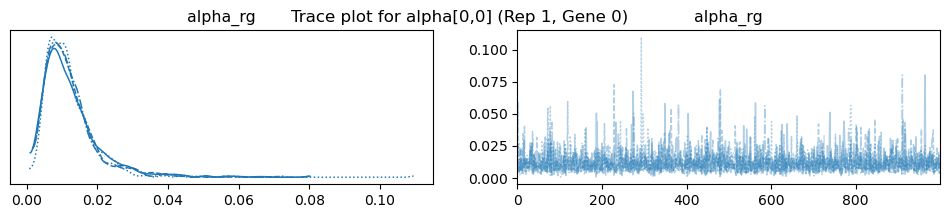

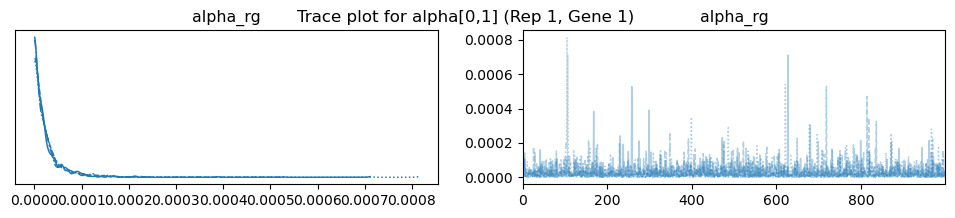

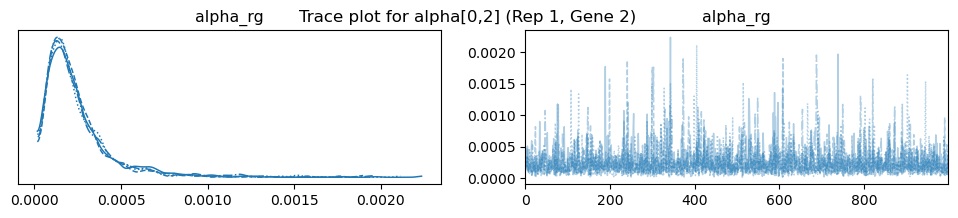

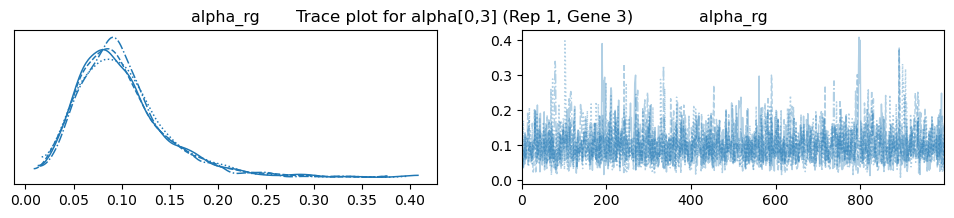

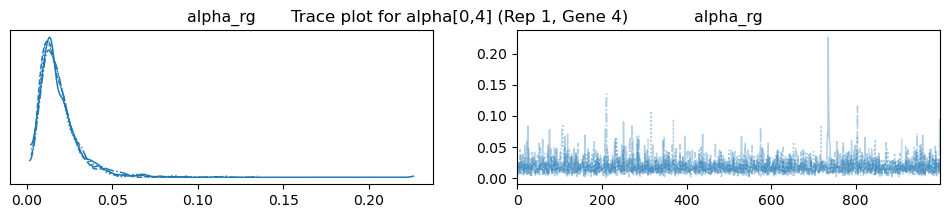

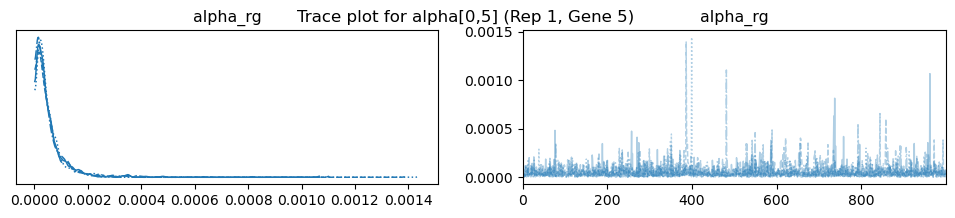

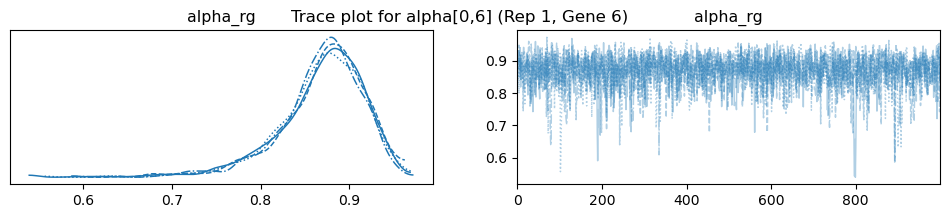

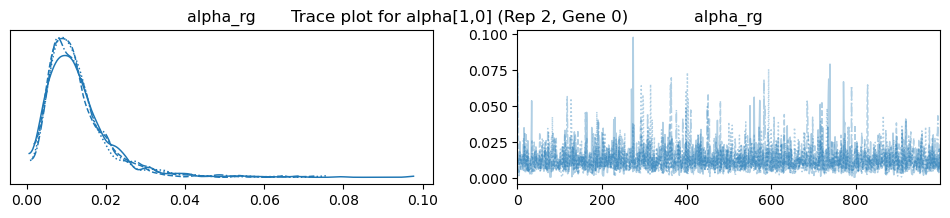

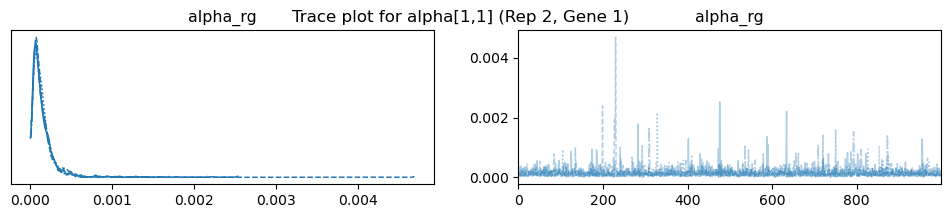

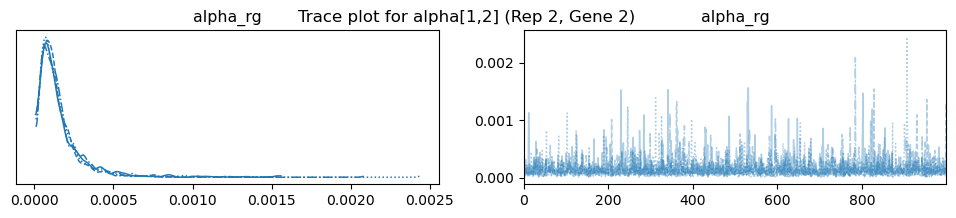

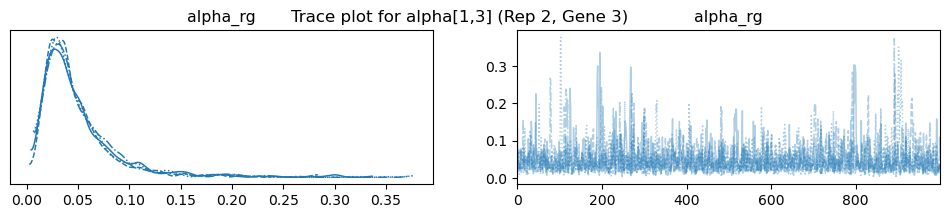

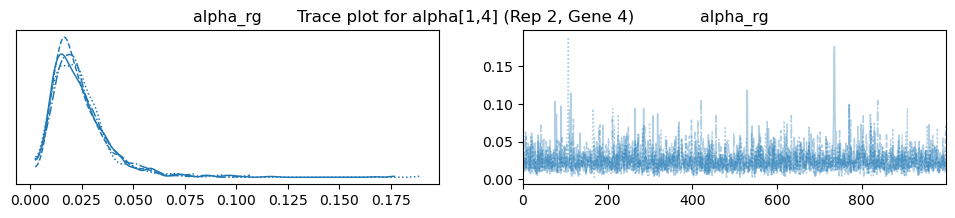

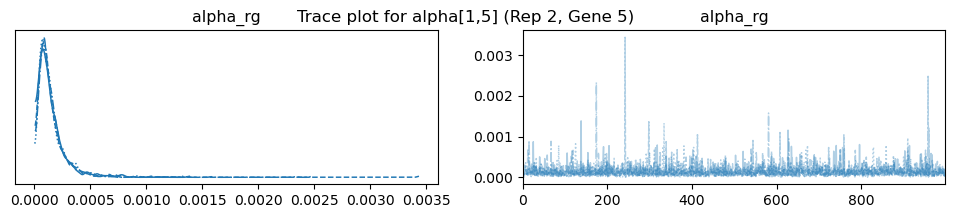

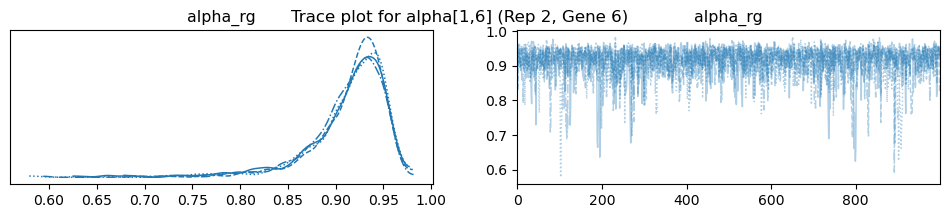

In [9]:
for r in range(R):
    for g in range(G):
        var_name = f"alpha[{r},{g}]"
        # Extract samples for this replicate and gene
        alpha_rg = trace.posterior['alpha'].isel(alpha_dim_0=r, alpha_dim_1=g).to_dataset(name='alpha_rg')
        
        # Create a copy of the trace object with just this variable
        idata_rg = trace.copy()
        idata_rg.posterior = alpha_rg

        # Plot the trace
        az.plot_trace(idata_rg, var_names=['alpha_rg'])
        plt.suptitle(f"Trace plot for alpha[{r},{g}] (Rep {r+1}, Gene {g})")
        plt.show()


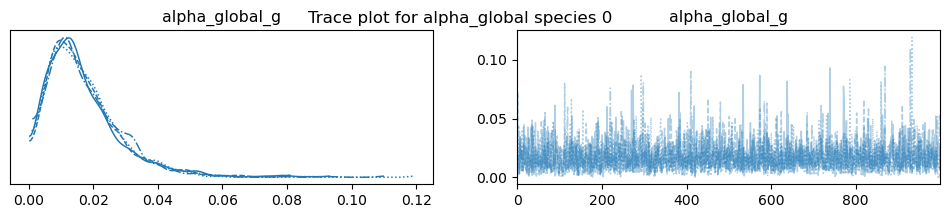

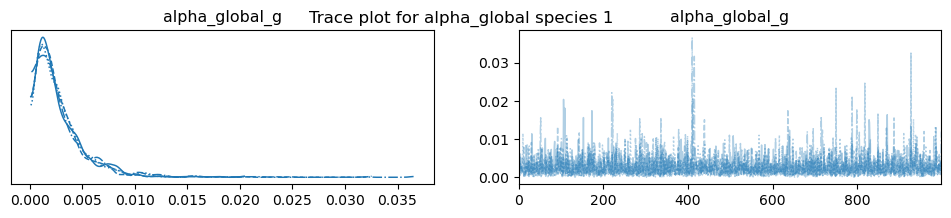

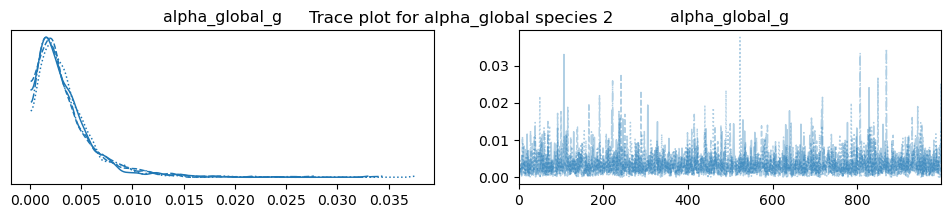

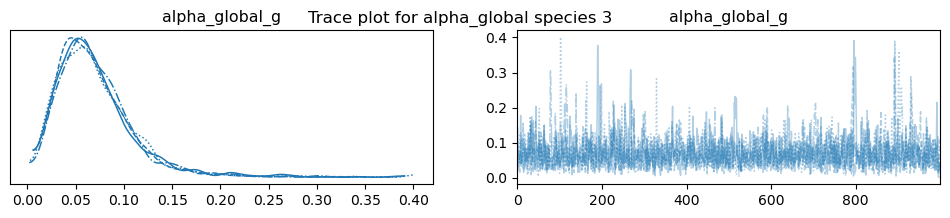

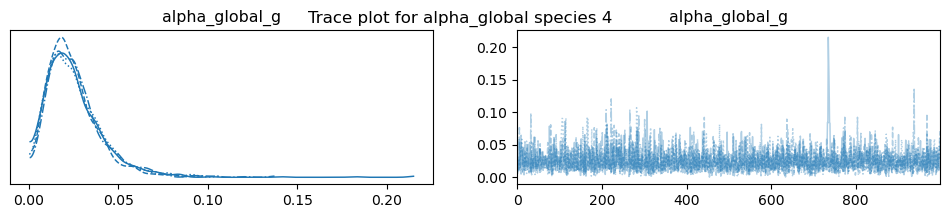

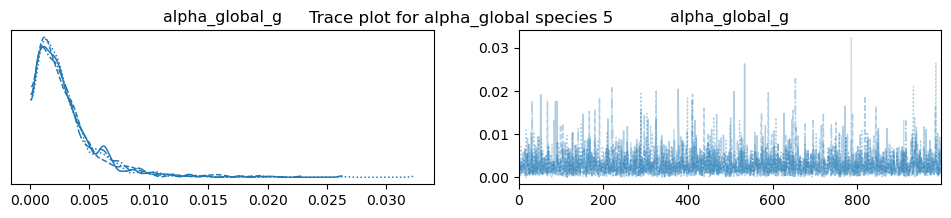

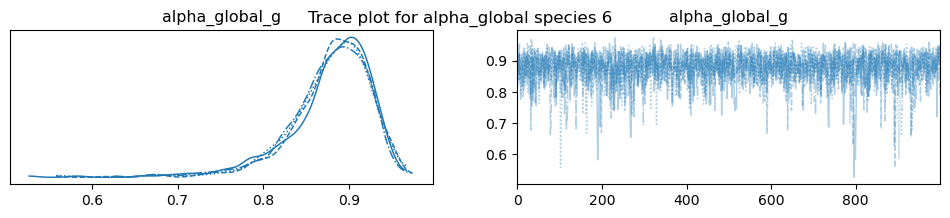

In [10]:
for g in range(G):
    var_name = f"alpha_global[{g}]"
    # Extract samples for this gene
    alpha_global_g = trace.posterior['alpha_global'].isel(alpha_global_dim_0=g).to_dataset(name='alpha_global_g')
    
    # Create a copy of the trace object with just this variable
    idata_g = trace.copy()
    idata_g.posterior = alpha_global_g

    # Plot the trace
    az.plot_trace(idata_g, var_names=['alpha_global_g'])
    plt.suptitle(f"Trace plot for alpha_global species {g}")
    plt.show()


array([[<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>]], dtype=object)

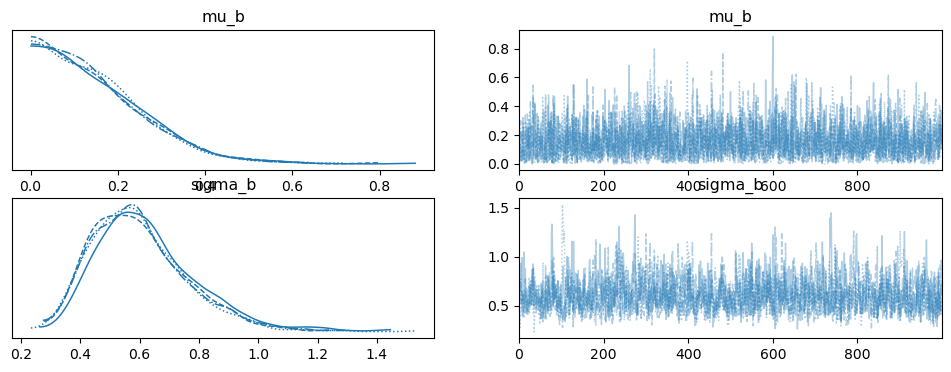

In [11]:
az.plot_trace(trace, var_names = ['mu_b', 'sigma_b'])

array([[<Axes: title={'center': 'X_mrna'}>,
        <Axes: title={'center': 'X_mrna'}>],
       [<Axes: title={'center': 'conc'}>,
        <Axes: title={'center': 'conc'}>]], dtype=object)

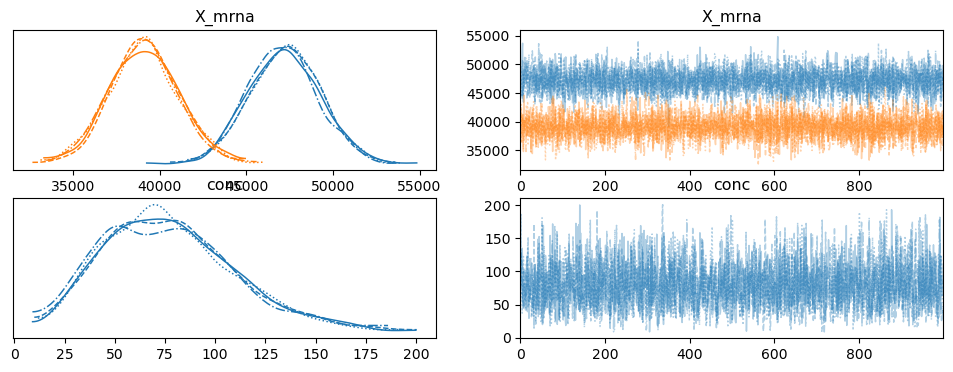

In [12]:
az.plot_trace(trace, var_names = ['X_mrna', 'conc'])

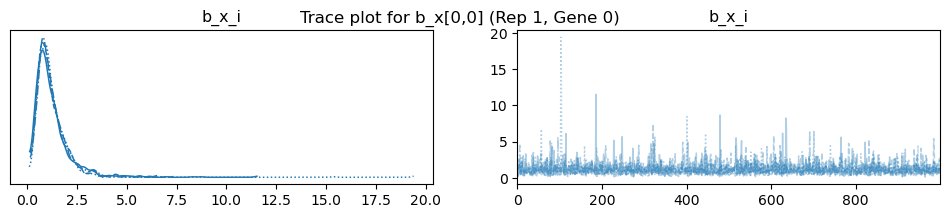

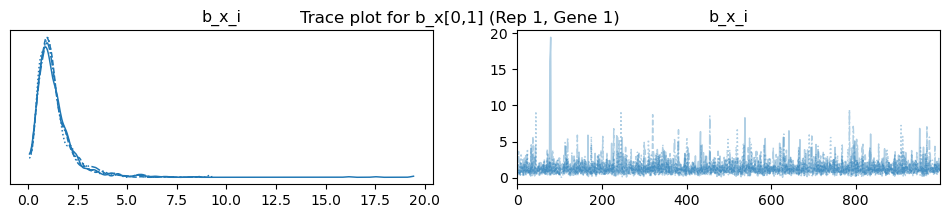

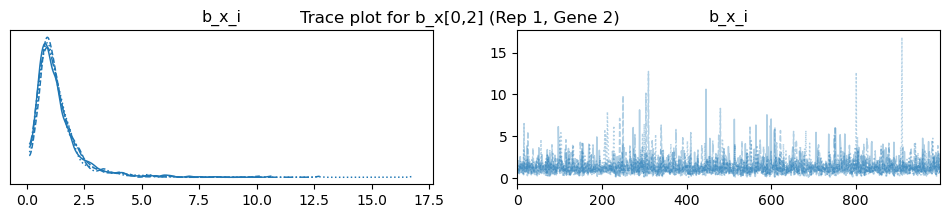

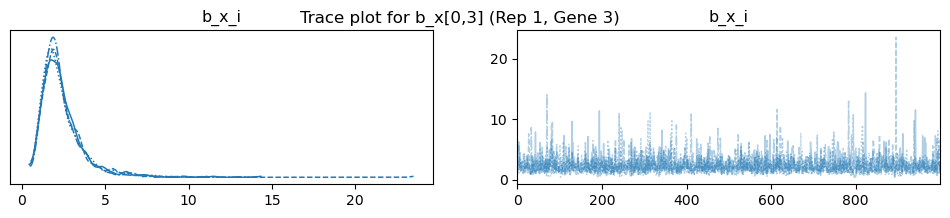

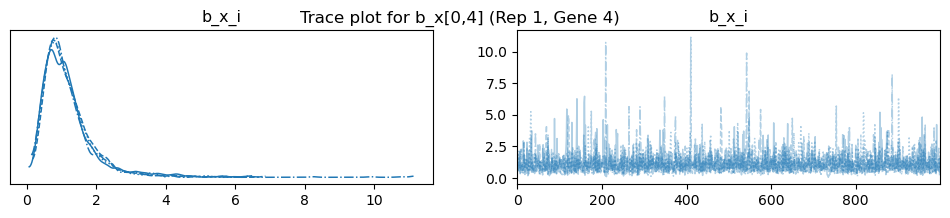

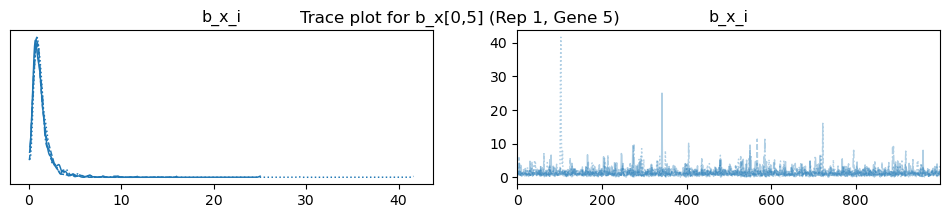

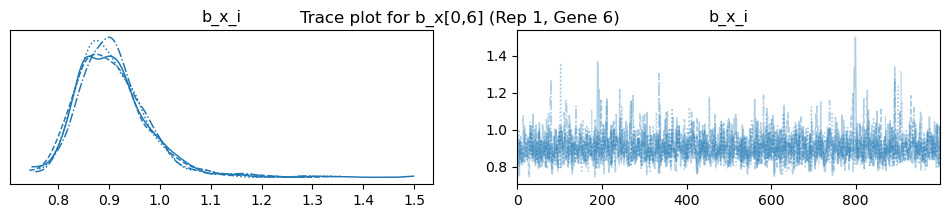

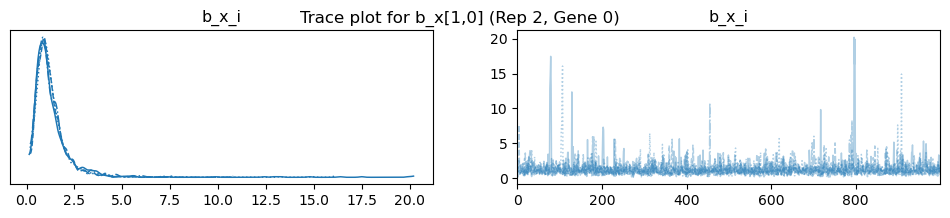

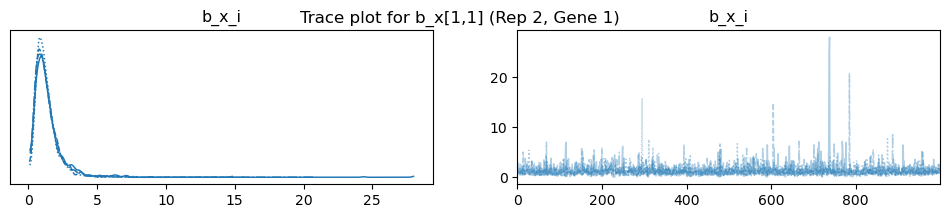

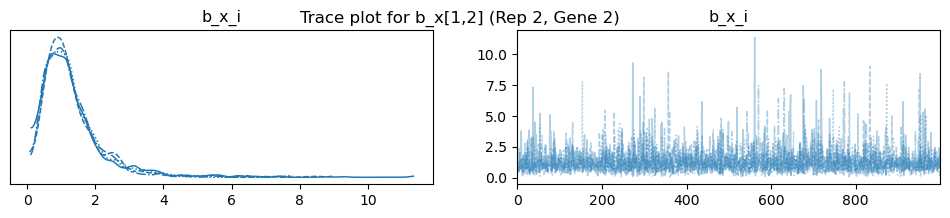

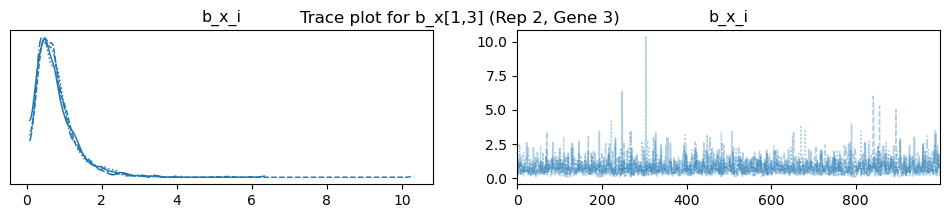

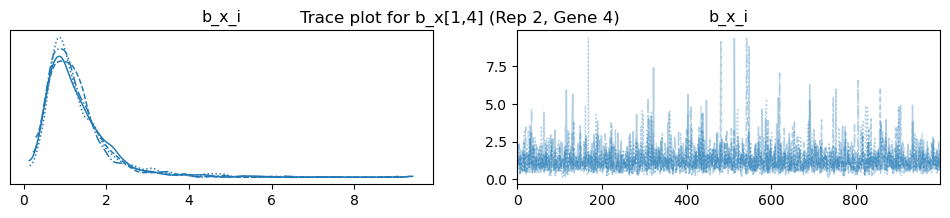

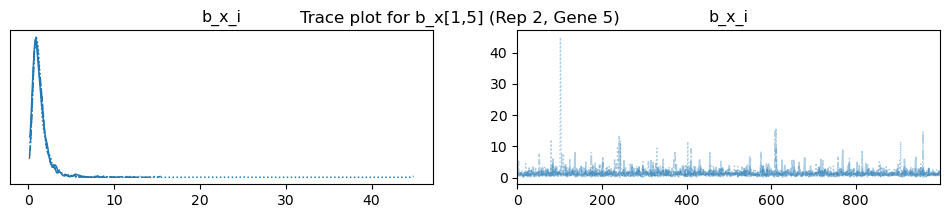

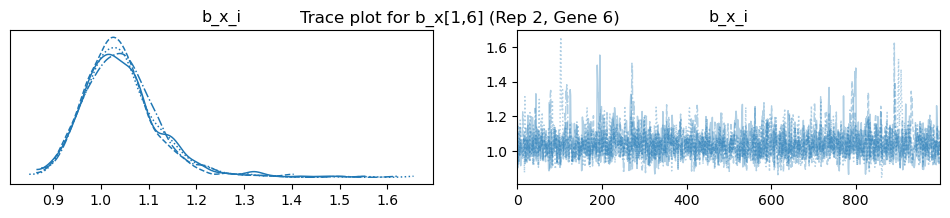

In [13]:
for r in range(R):
    for g in range(G):
        var_name = f"b_x[{r},{g}]"
        b_x_i = trace.posterior['b_x'].isel(b_x_dim_0=r, b_x_dim_1 = g).to_dataset(name='b_x_i')
    
        idata_i = trace.copy()
        idata_i.posterior = b_x_i
    
        az.plot_trace(idata_i, var_names=['b_x_i'])
        #plt.suptitle(f"Trace plot for b_x species {i}")
        plt.suptitle(f"Trace plot for b_x[{r},{g}] (Rep {r+1}, Gene {g})")

        plt.show()
    

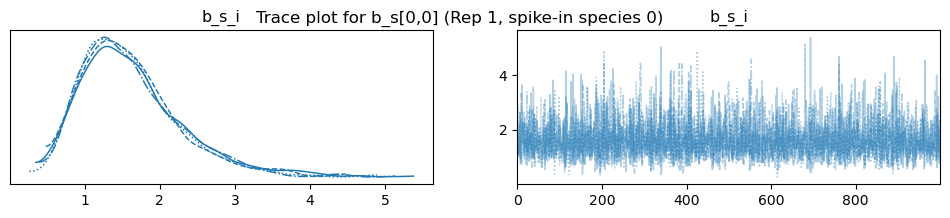

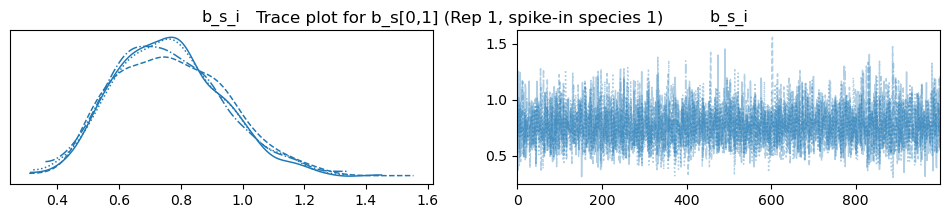

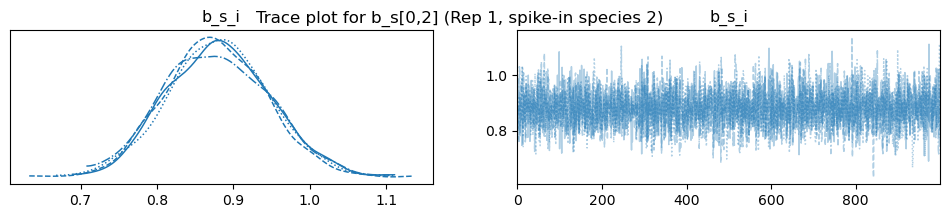

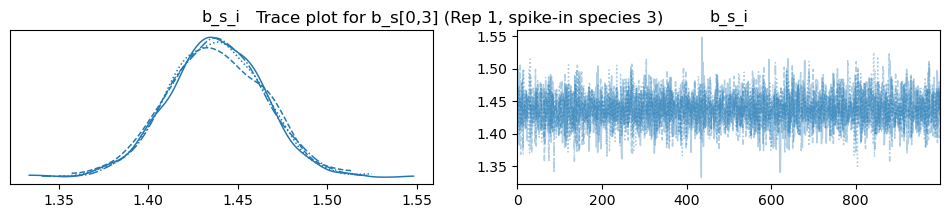

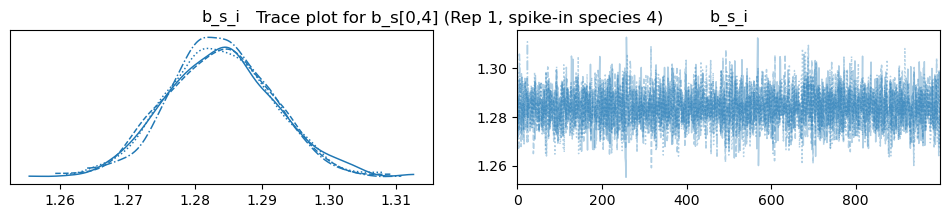

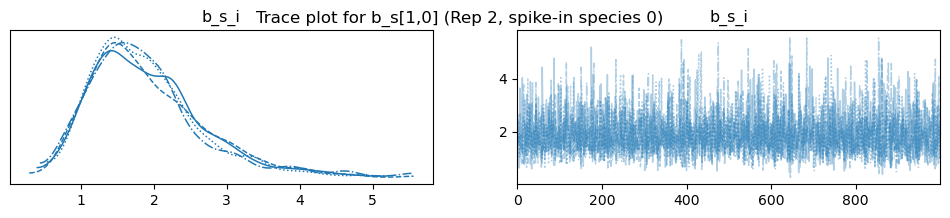

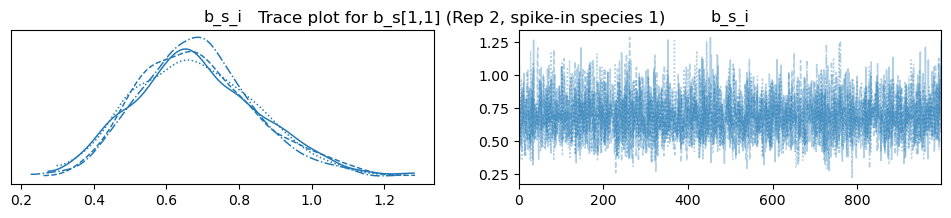

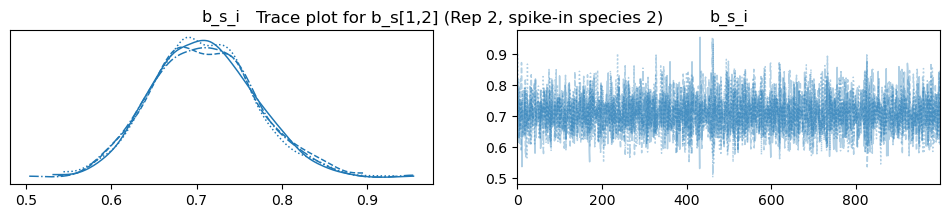

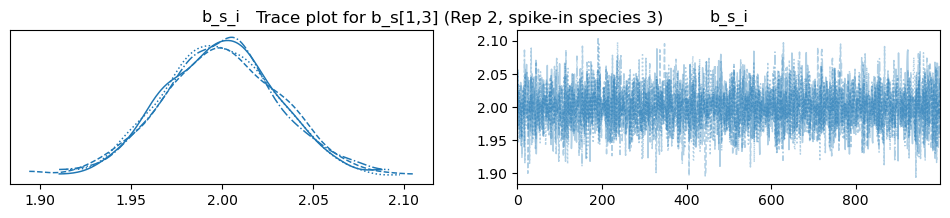

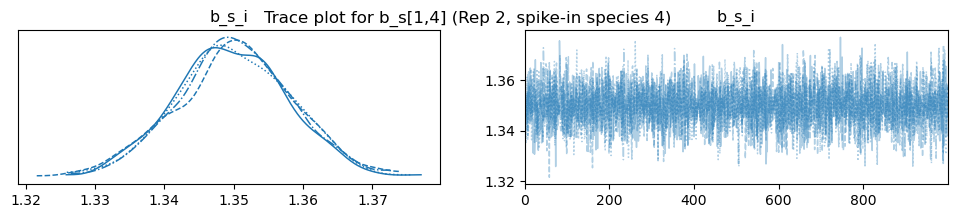

In [14]:
for r in range(R):
    for k in range(K):
        var_name = f"b_s[{r},{k}]"
        b_s_i = trace.posterior['b_s'].isel(b_s_dim_0=r, b_s_dim_1 = k).to_dataset(name='b_s_i')
    
        idata_i = trace.copy()
        idata_i.posterior = b_s_i
    
        az.plot_trace(idata_i, var_names=['b_s_i'])
        #plt.suptitle(f"Trace plot for b_x species {i}")
        plt.suptitle(f"Trace plot for b_s[{r},{k}] (Rep {r+1}, spike-in species {k})")

        plt.show()
    

## Nonidentifiability checks
### X_mrna vs b_x

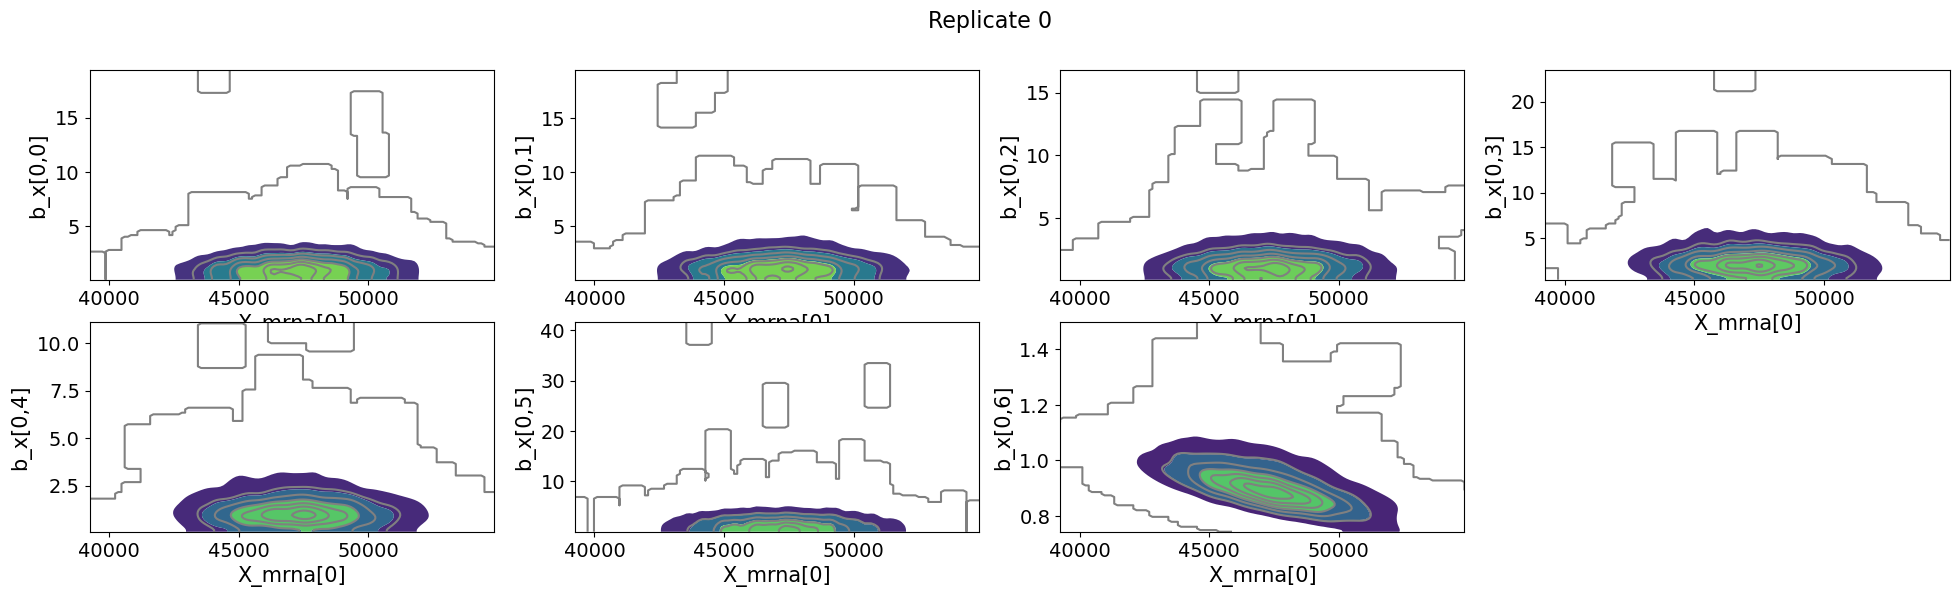

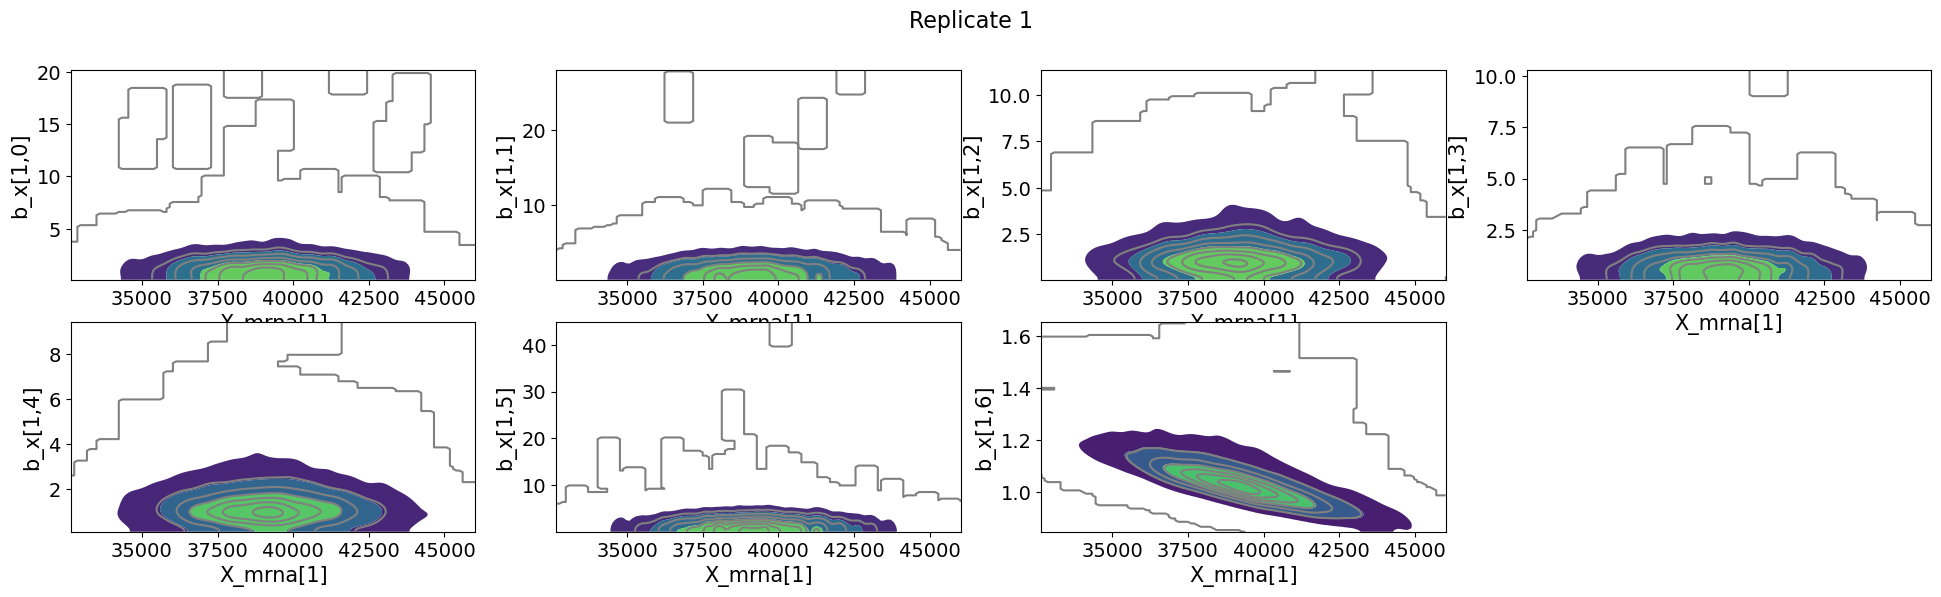

In [15]:
ncols = 4
nrows = (G + ncols - 1) // ncols  # ceiling division

for rep in range(R):  # loop through replicates
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 3*nrows))
    axes = axes.flatten()
    fig.suptitle(f"Replicate {rep}", fontsize=16)

    for g in range(G):
        b_x_i = trace.posterior['b_x'].isel(b_x_dim_0=rep, b_x_dim_1 = g)
        X_mrna_i = trace.posterior['X_mrna'].isel(X_mrna_dim_0=rep)

        az.plot_pair(
            {'X_mrna[{}]'.format(rep): X_mrna_i, 'b_x[{},{}]'.format(rep, g): b_x_i},
            kind='kde',
            ax=axes[g]
        )

    # Hide any unused axes
    for j in range(G, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### X_mrna vs alpha

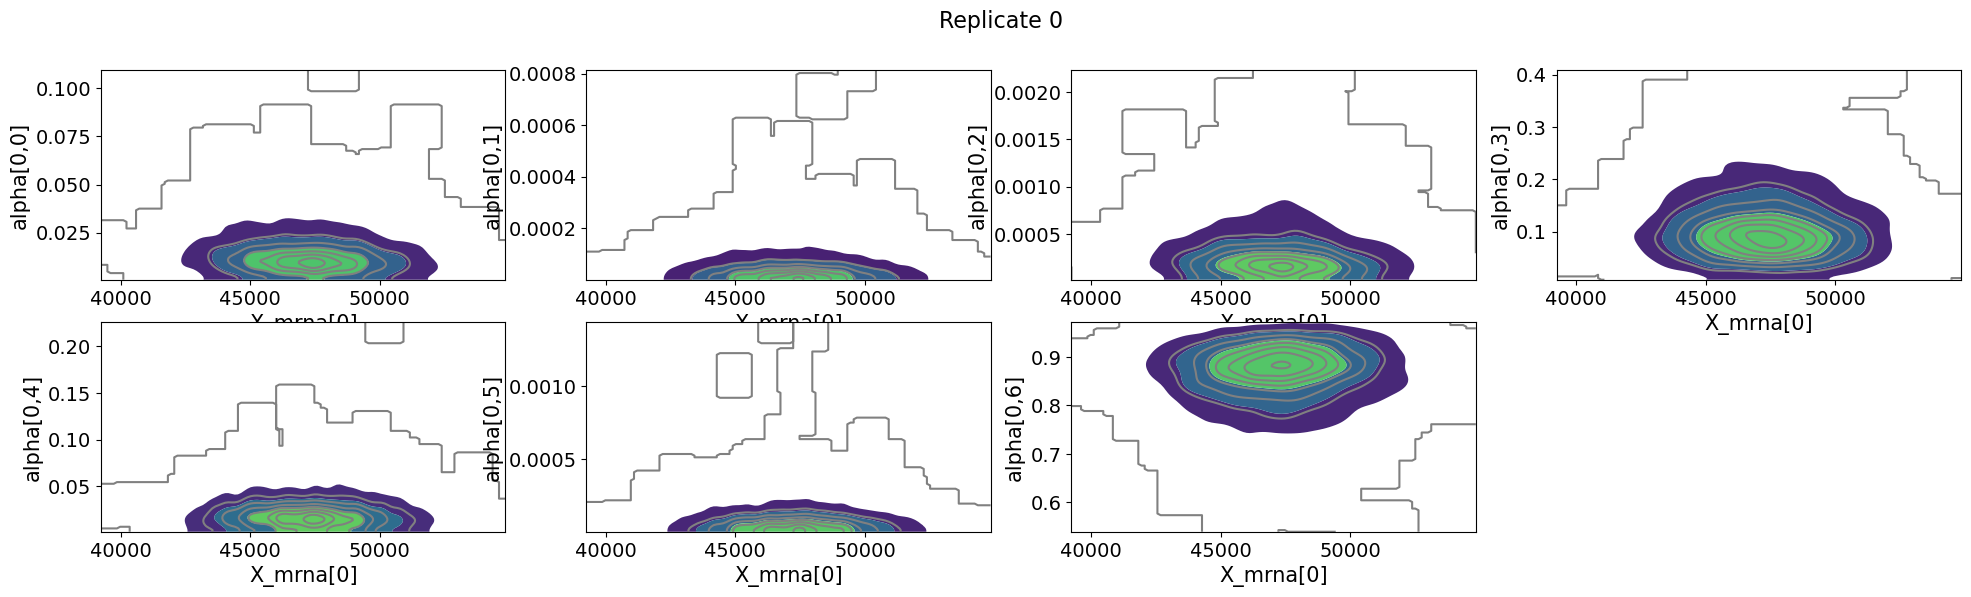

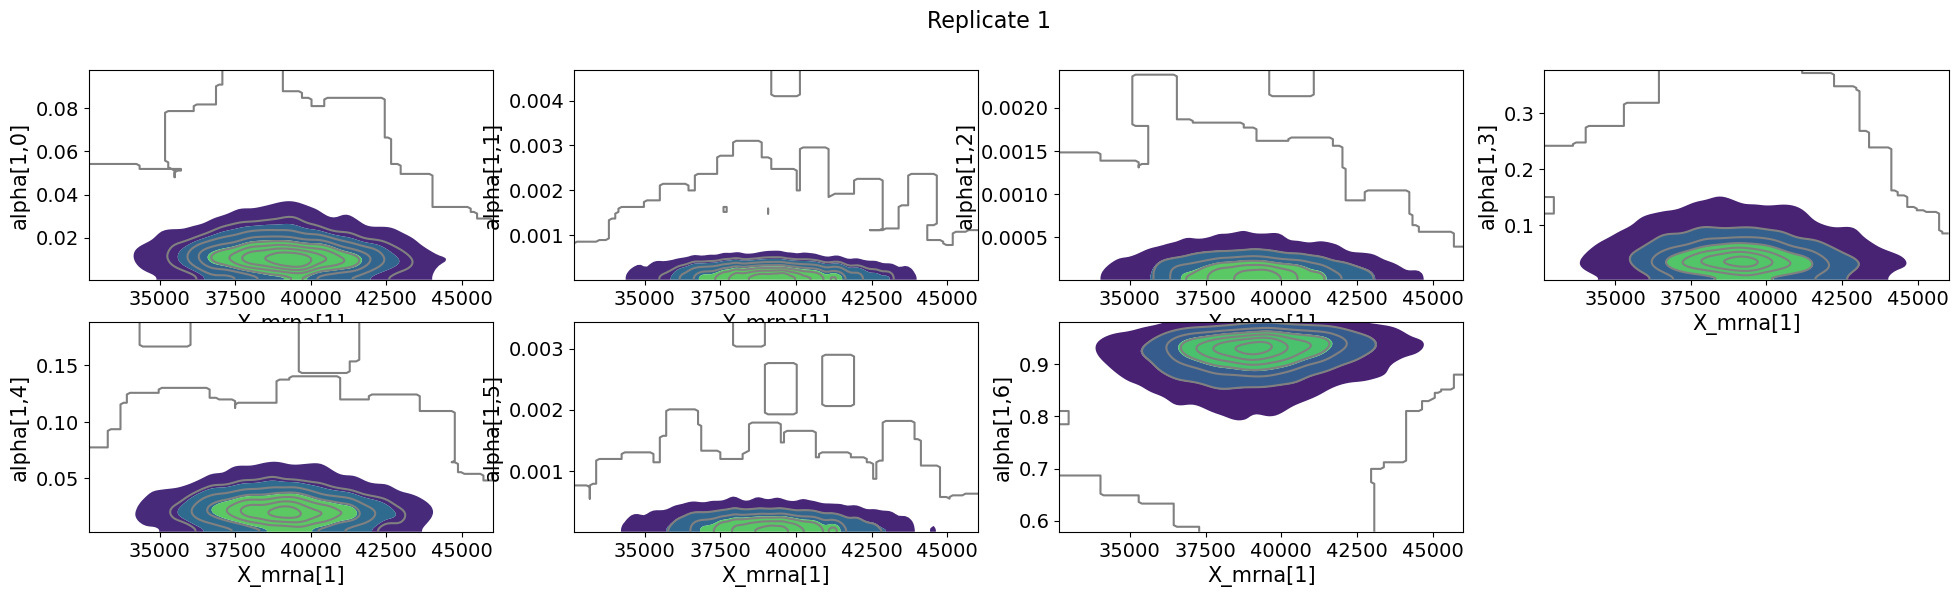

In [16]:
ncols = 4
nrows = (G + ncols - 1) // ncols  # ceiling division

for rep in range(R):  # loop through replicates
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 3*nrows))
    axes = axes.flatten()
    fig.suptitle(f"Replicate {rep}", fontsize=16)

    for g in range(G):
        alpha_i = trace.posterior['alpha'].isel(alpha_dim_0=rep, alpha_dim_1 = g)
        X_mrna_i = trace.posterior['X_mrna'].isel(X_mrna_dim_0=rep)

        az.plot_pair(
            {'X_mrna[{}]'.format(rep): X_mrna_i, 'alpha[{},{}]'.format(rep, g): alpha_i},
            kind='kde',
            ax=axes[g]
        )

    # Hide any unused axes
    for j in range(G, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### alpha vs b_x

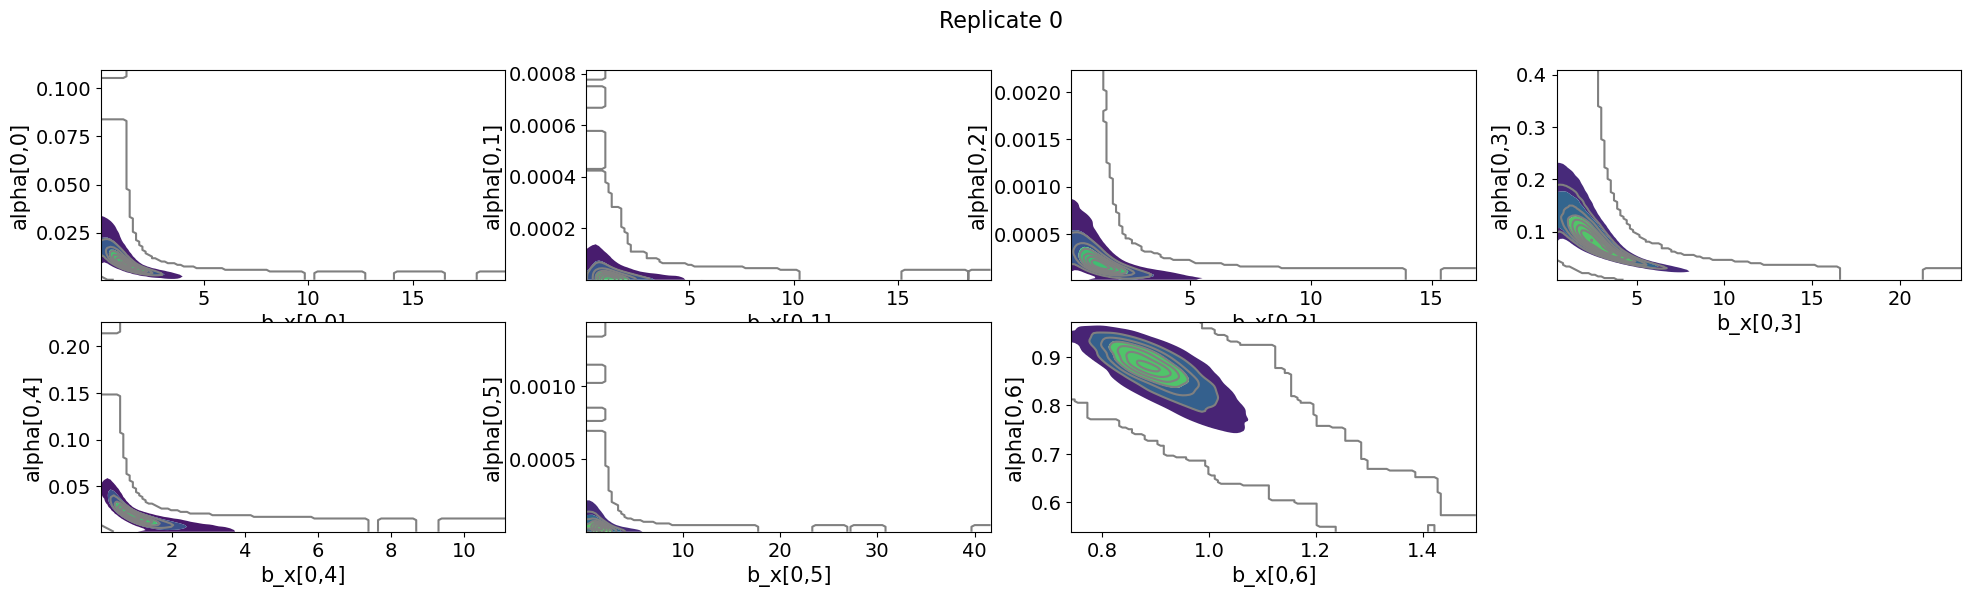

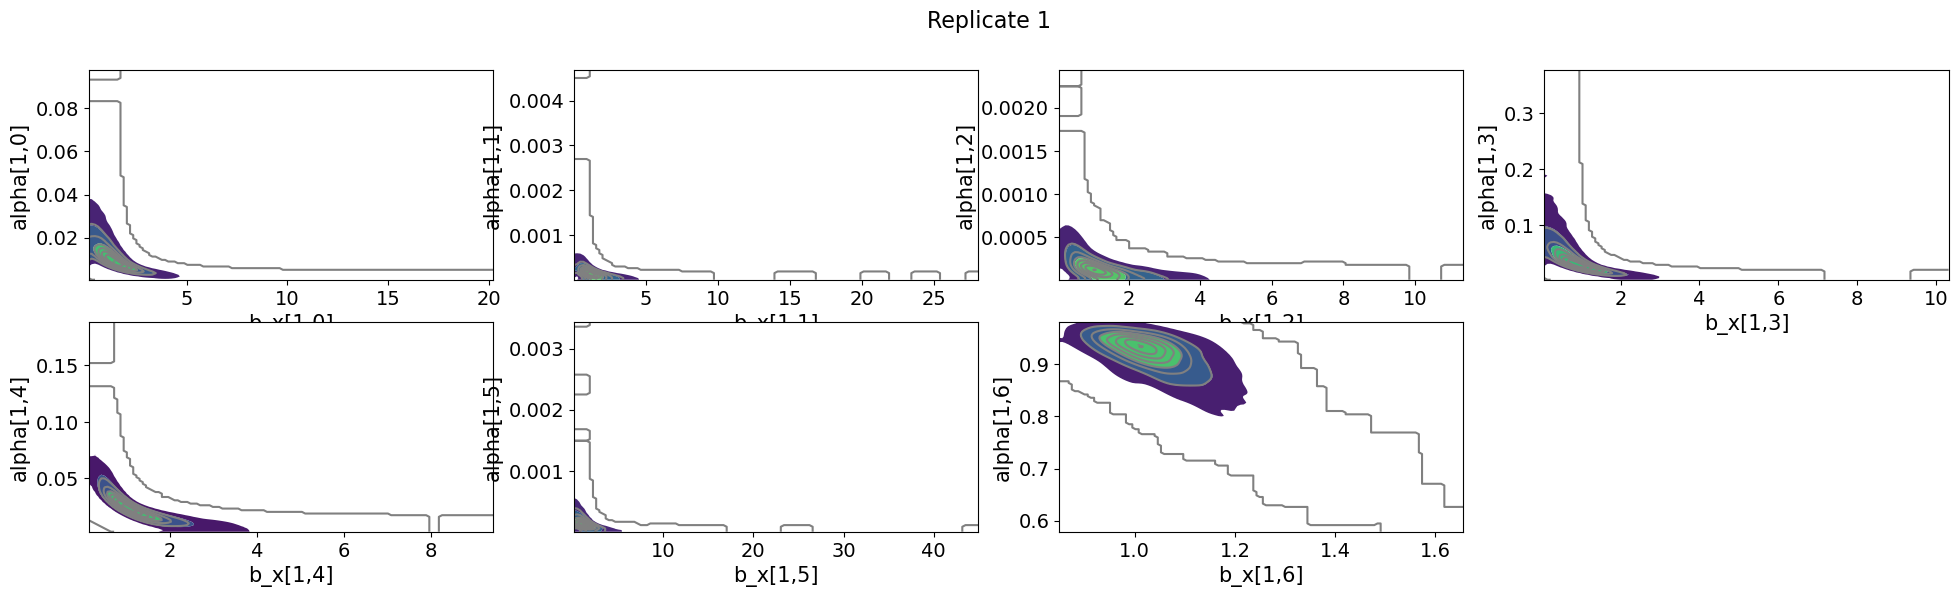

In [17]:
#import matplotlib.pyplot as plt
#import arviz as az

ncols = 4
nrows = (G + ncols - 1) // ncols  # ceiling division

for rep in range(R):  # loop through replicates
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 3*nrows))
    axes = axes.flatten()
    fig.suptitle(f"Replicate {rep}", fontsize=16)

    for g in range(G):
        b_x_i = trace.posterior['b_x'].isel(b_x_dim_0=rep, b_x_dim_1 = g)
        alpha_i = trace.posterior['alpha'].isel(alpha_dim_0=rep, alpha_dim_1=g)

        az.plot_pair(
            {'b_x[{},{}]'.format(rep, g): b_x_i, 'alpha[{},{}]'.format(rep, g): alpha_i},
            kind='kde',
            ax=axes[g]
        )

    # Hide any unused axes
    for j in range(G, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### alpha vs b_s

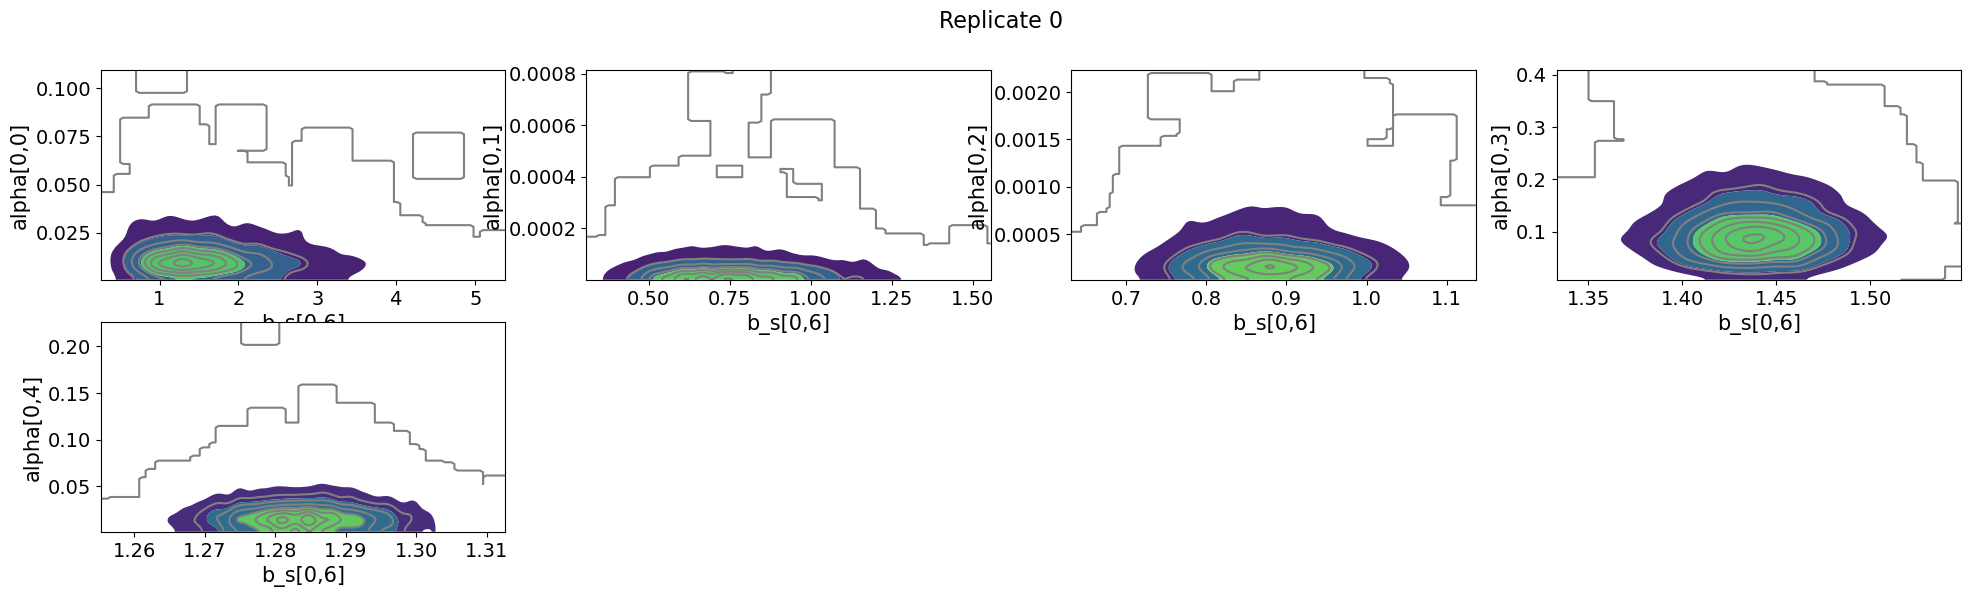

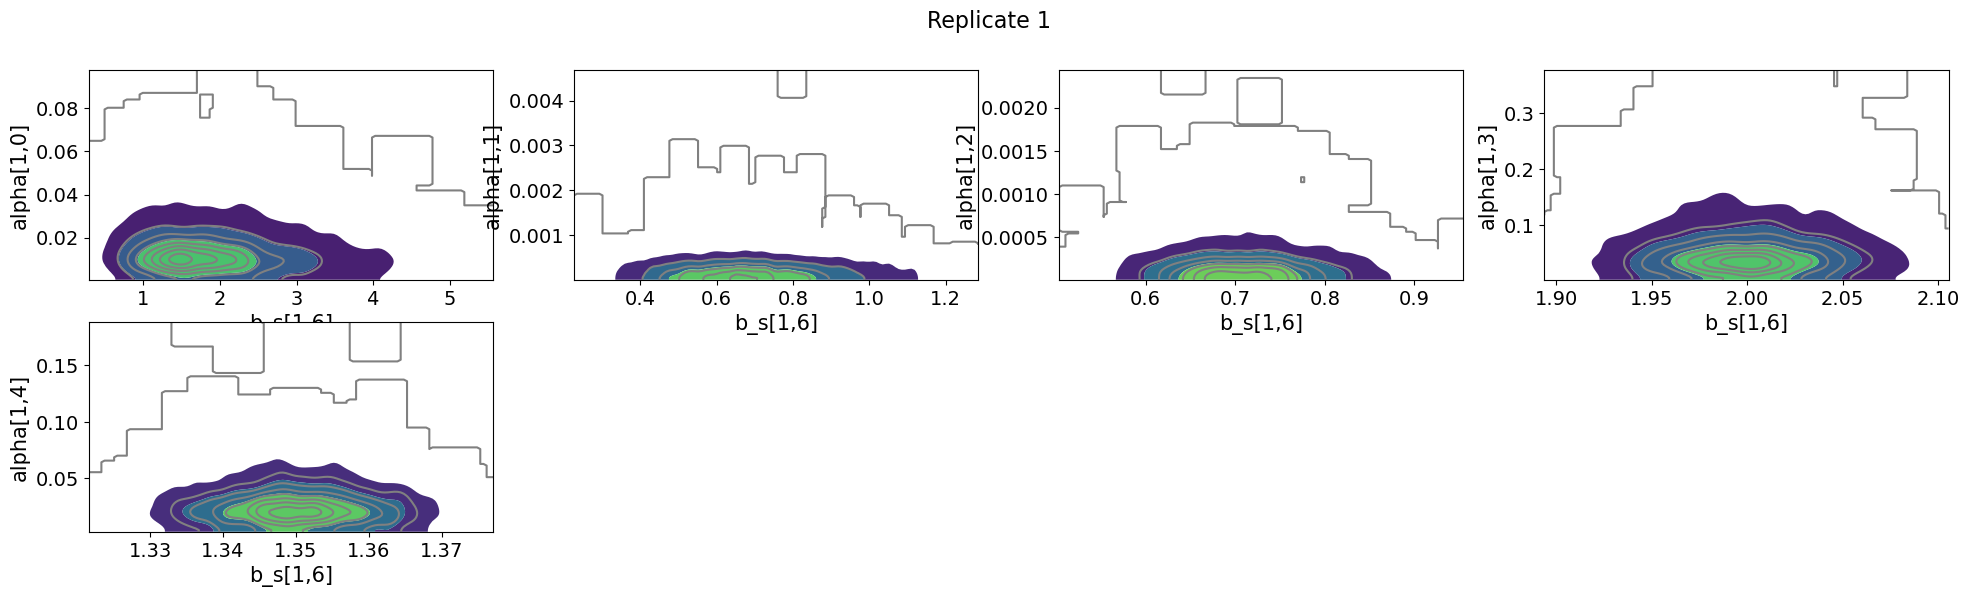

In [18]:
#import matplotlib.pyplot as plt
#import arviz as az

ncols = 4
nrows = (K + ncols - 1) // ncols  # ceiling division

for rep in range(R):  # loop through replicates
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 3*nrows))
    axes = axes.flatten()
    fig.suptitle(f"Replicate {rep}", fontsize=16)

    for k in range(K):
        b_s_i = trace.posterior['b_s'].isel(b_s_dim_0=rep, b_s_dim_1 = k)
        alpha_i = trace.posterior['alpha'].isel(alpha_dim_0=rep, alpha_dim_1=k)

        az.plot_pair(
            {'b_s[{},{}]'.format(rep, g): b_s_i, 'alpha[{},{}]'.format(rep, k): alpha_i},
            kind='kde',
            ax=axes[k]
        )

    # Hide any unused axes
    for j in range(K, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='X_mrna\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n0, 1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n0, 2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n0, 3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n0, 4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b_s\n1, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='X_mrna\n0', ylabel='b_s\n1, 1'>,
        <Axes: xlabel='X_mrna\n1'>, <Axes: xlabel='b_s\n0, 0'>,
        <Axes: xlabel='b_s\n0, 1'>, <Axes: xlabel='b_s\n0, 2'>,
        <Ax

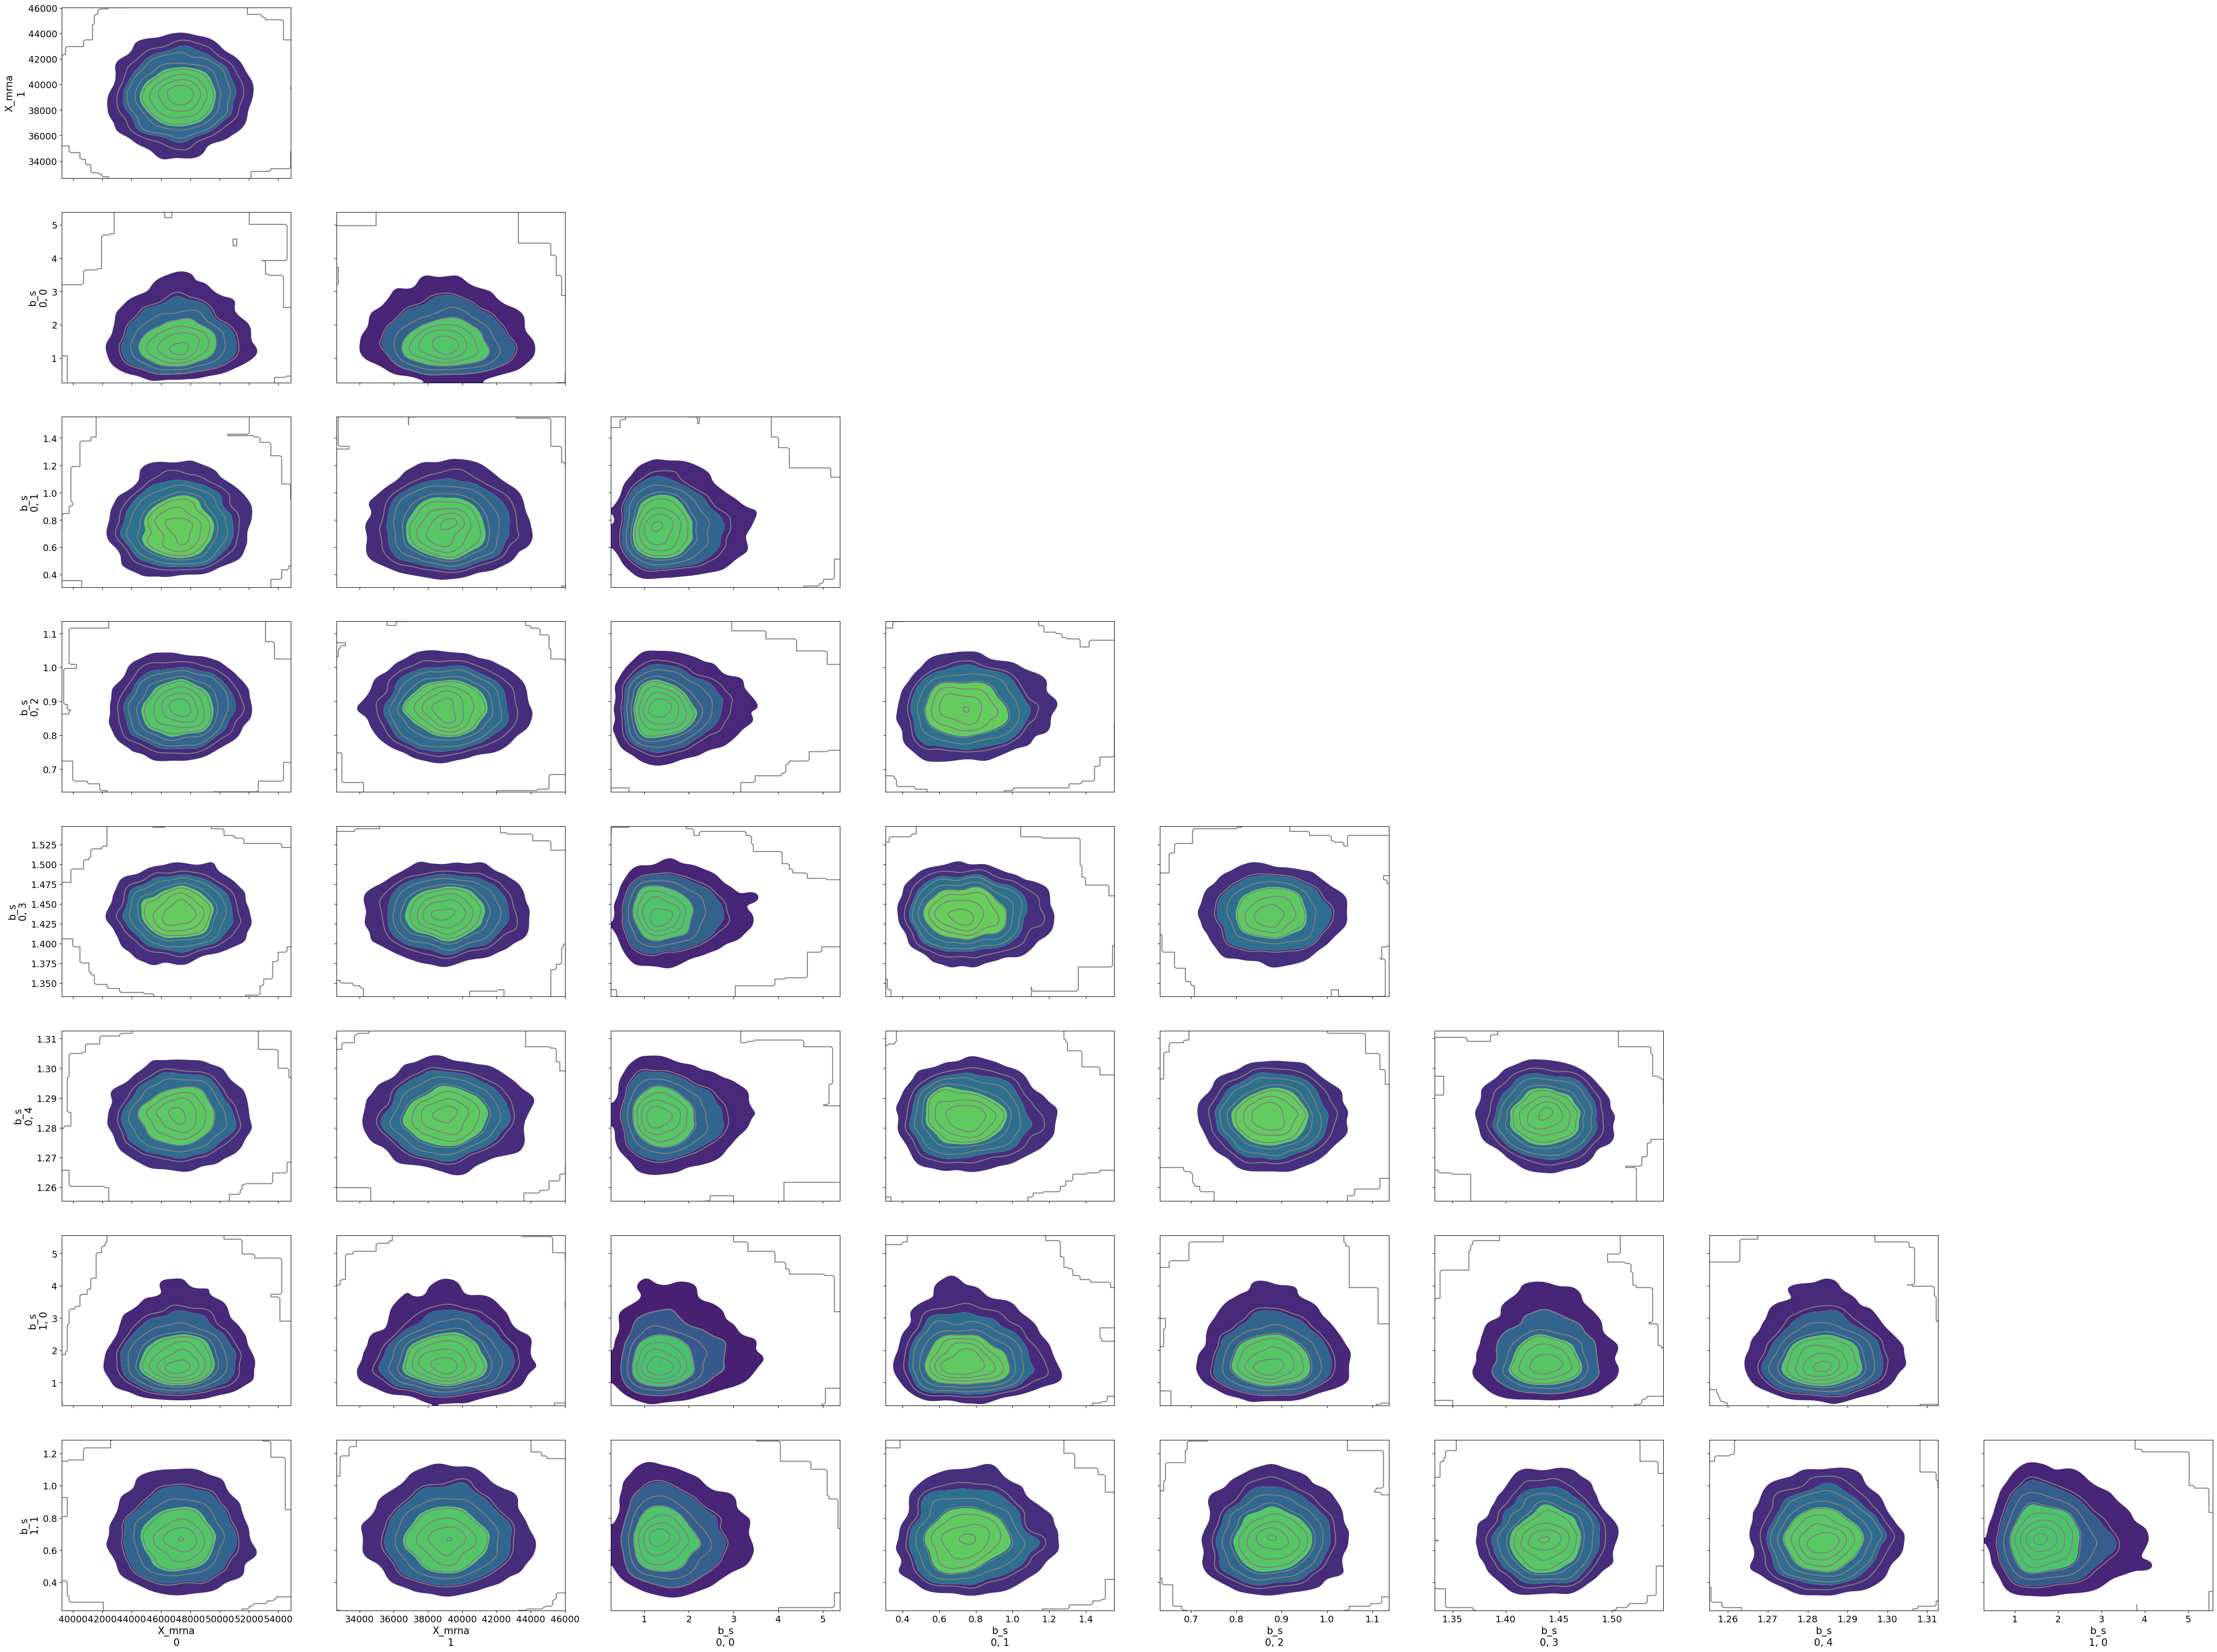

In [19]:
az.plot_pair(trace, var_names = [ 'X_mrna', 'b_s',], kind = 'kde')

In [20]:
%load_ext watermark
%watermark -v -p numpy,bokeh,pymc,arviz,bebi103,iqplot,pandas,matplotlib,colorcet,tqdm,jupyterlab

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/bebi103/viz.py:38: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

numpy     : 1.26.4
bokeh     : 3.7.3
pymc      : 5.19.1
arviz     : 0.21.0
bebi103   : 0.1.26
iqplot    : 0.3.7
pandas    : 2.2.3
matplotlib: 3.9.4
colorcet  : 3.1.0
tqdm      : 4.67.1
jupyterlab: 4.3.3

